反卷积上采样块

In [41]:
import os
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard.writer import SummaryWriter
from torchsummary import summary
import datetime
import matplotlib.pyplot as plt

In [42]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.manual_seed(26)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32
num_epochs = 20
learning_rate = 0.0002
# in_channels：latent dim ；out_channels: latent dim -> c*1*1 -(deconv)->c*4*4
in_channels, out_channels = 100, 512
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))

生成器残差块和Reshape层

In [43]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.out_channels = in_channels
        self.deconv1 = nn.ConvTranspose2d(in_channels, in_channels//4, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=in_channels//4)
        self.deconv2 = nn.ConvTranspose2d(in_channels//4, in_channels//4, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=in_channels//4)
        self.deconv3 = nn.ConvTranspose2d(in_channels//4, self.out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(num_features=self.out_channels)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        identity = x
        out = self.deconv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.deconv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.deconv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)
        return out

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    
    def forward(self, x):
        return x.view((x.size(0),)+self.shape)


生成器网络架构

In [44]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.out_channels = out_channels
        # 100 -> 1024
        self.mlp = nn.Linear(in_channels, out_channels, bias=True)
        self.reshape = Reshape(out_channels, 1, 1)
        # 1*1*c -> 4*4*c
        self.deconv1 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 4*4*c -> 8*8*c/2
        self.deconv2 = nn.ConvTranspose2d(out_channels, out_channels//2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels//2)
        # resblock
        self.resblock2_1 = ResBlock(out_channels//2)

        # 8*8*c/2 -> 16*16*c/4
        self.deconv3 = nn.ConvTranspose2d(out_channels//2, out_channels//4, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels//4)
        # resblock
        self.resblock3_1 = ResBlock(out_channels//4)

        # 16*16*c/4 -> 32*32*c/8
        self.deconv4 = nn.ConvTranspose2d(out_channels//4, out_channels//8, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(out_channels//8)
        # resblock
        self.resblock4_1 = ResBlock(out_channels//8)
        
        # 32*32*c/8 -> 64*64*c/16
        self.deconv5 = nn.ConvTranspose2d(out_channels//8, out_channels//16, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(out_channels//16)
        # resblock
        self.resblock5_1 = ResBlock(out_channels//16)

        # final deconv
        self.deconv_final = nn.ConvTranspose2d(out_channels//16, 3, kernel_size=1, stride=1, padding=0)
        self.bn_finale = nn.BatchNorm2d(3)
        self.tanh = nn.Tanh()
        self.relu = nn.LeakyReLU()
    
    def forward(self, x):
        # x:100
        # out: c
        out = self.mlp(x)
        out = self.reshape(out)
        out = self.deconv1(out)
        out = self.relu(out)
        # out = self.bn1(out)

        out = self.deconv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.resblock2_1(out)

        out = self.deconv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.resblock3_1(out)

        out = self.deconv4(out)
        out = self.bn4(out)
        out = self.relu(out)
        out = self.resblock4_1(out)

        out = self.deconv5(out)
        out = self.bn5(out)
        out = self.relu(out)
        out = self.resblock5_1(out)
        out = self.deconv_final(out)
        # out = self.bn_finale(out)
        out = self.tanh(out)
        return out

In [45]:
net_G = nn.Sequential(Generator(in_channels=100, out_channels=1024))

X = torch.randn(size=(1, 100))
for layer in net_G:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Generator output shape:	 torch.Size([1, 3, 64, 64])


卷积残差块

In [46]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.leaky_relu((self.bn1(self.conv1(X))))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.leaky_relu(Y)

判别器架构

In [47]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [48]:
net_D = nn.Sequential(Discriminator())

X = torch.randn(size=(2, 3, 64, 64))
for layer in net_D:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Discriminator output shape:	 torch.Size([2, 1])


定义权重初始化函数

In [49]:
def init_weights(m):
    classname = m.__class__.__name__
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_normal_(m.weight)
    # elif type(m) == nn.BatchNorm2d:
    #     nn.init.xavier_normal_(m.weight)
    #     nn.init.zeros_(m.bias)

生成器初始化

In [50]:
generator = Generator(in_channels, out_channels).to(device)
generator.apply(init_weights)
print(generator)

Generator(
  (mlp): Linear(in_features=100, out_features=512, bias=True)
  (reshape): Reshape()
  (deconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock2_1): ResBlock(
    (deconv1): ConvTranspose2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv3): ConvTranspose2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyRe

In [53]:
summary(generator, (1,100))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 512]              51,712
├─Reshape: 1-2                           [-1, 512, 1, 1]           --
├─ConvTranspose2d: 1-3                   [-1, 512, 4, 4]           4,194,816
├─LeakyReLU: 1-4                         [-1, 512, 4, 4]           --
├─ConvTranspose2d: 1-5                   [-1, 256, 8, 8]           2,097,408
├─BatchNorm2d: 1-6                       [-1, 256, 8, 8]           512
├─LeakyReLU: 1-7                         [-1, 256, 8, 8]           --
├─ResBlock: 1-8                          [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-1              [-1, 64, 8, 8]            16,448
|    └─BatchNorm2d: 2-2                  [-1, 64, 8, 8]            128
|    └─LeakyReLU: 2-3                    [-1, 64, 8, 8]            --
|    └─ConvTranspose2d: 2-4              [-1, 64, 8, 8]            36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 8, 8]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 512]              51,712
├─Reshape: 1-2                           [-1, 512, 1, 1]           --
├─ConvTranspose2d: 1-3                   [-1, 512, 4, 4]           4,194,816
├─LeakyReLU: 1-4                         [-1, 512, 4, 4]           --
├─ConvTranspose2d: 1-5                   [-1, 256, 8, 8]           2,097,408
├─BatchNorm2d: 1-6                       [-1, 256, 8, 8]           512
├─LeakyReLU: 1-7                         [-1, 256, 8, 8]           --
├─ResBlock: 1-8                          [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-1              [-1, 64, 8, 8]            16,448
|    └─BatchNorm2d: 2-2                  [-1, 64, 8, 8]            128
|    └─LeakyReLU: 2-3                    [-1, 64, 8, 8]            --
|    └─ConvTranspose2d: 2-4              [-1, 64, 8, 8]            36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 8, 8]  

判别器初始化

In [54]:
discriminator = Discriminator().to(device)
discriminator.apply(init_weights)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

In [55]:
summary(discriminator, (3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

定义加载数据集与数据预处理的函数

In [56]:
batch_size = 32
train_transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_dataset = datasets.ImageFolder(root='/mnt/e/Code/PythonProjects/TF2/cDCGAN/facescrub/train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

查看数据流

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


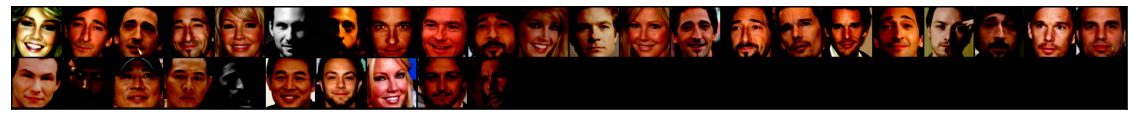

In [57]:
show_batch(train_loader)

定义损失函数

In [ ]:
adversarial_loss = nn.BCELoss()

def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    return gen_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

定义模型和优化器

In [ ]:
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [ ]:
fixed_noise = torch.randn(128, in_channels, device=device)
real_label = 1
fake_label = 0

训练代码

In [ ]:
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
      
        real_target = Variable(torch.ones(real_images.size(0)).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0)).to(device))
        
        real_target = real_target.unsqueeze(1)
        fake_target = fake_target.unsqueeze(1)

        D_real_loss = discriminator_loss(discriminator(real_images), real_target)
        # print(discriminator(real_images))
        D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), in_channels, device=device)  
        noise_vector = noise_vector.to(device)
    
        generated_image = generator(noise_vector)
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        D_fake_loss.backward()
      
        D_total_loss = D_real_loss + D_fake_loss
        D_loss_list.append(D_total_loss)
      
        #D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator(generated_image), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_image(generated_image.data[:50], 'dcgan/torch/images/sample_%d'%epoch + '.png', nrow=5, normalize=True)
     
    torch.save(generator.state_dict(), 'dcgan/torch/training_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), 'dcgan/torch/training_weights/discriminator_epoch_%d.pth' % (epoch))